In [3]:
MODEL_ID = "fdbe5895-0327-49d9-83e9-2246dbe1858b"

DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101" # DOW
DATASET_ID2 = "3231bbe5eb2ab84eb54c9b64a8dcea55" # SPY

TRAINING_RUN = {
        "model_id": MODEL_ID,
        "datasets": [
            DATASET_ID1,
            DATASET_ID2
        ]
    }

In [4]:
#
# Get dataset from MI API #
#

import pandas
import sys
import gc
import uuid
import numpy as np

#!pip install --upgrade ../../../quantutils

import quantutils.dataset.pipeline as ppl
from quantutils.api.auth import CredentialsStore
from quantutils.api.bluemix import CloudObjectStore, ObjectStore, Metrics, Logger
from quantutils.api.marketinsights import MarketInsights, Dataset
from quantutils.api.assembly import MIAssembly
from quantutils.api.functions import Functions
import quantutils.model.utils as mlutils
from quantutils.model.ml import Model

cred = CredentialsStore()
metrics = Metrics(cred)
mi = MarketInsights(cred)
objStore = ObjectStore(cred)
cos = CloudObjectStore(cred)
log = Logger('MarketInsights-ML', cred)
fun = Functions(cred)
miassembly = MIAssembly(mi, fun)

# Logging helper function
tag = lambda x,y : "".join(["(", x, ":", str(y+1), ") "])

CONFIG = mi.get_model(MODEL_ID)
TRN_CNF = CONFIG['training']
TRAINING_RUN["id"] = cos.generateKey([str(TRAINING_RUN["datasets"]), str(TRAINING_RUN["model_id"])])
COS_BUCKET = "marketinsights-weights"

mkt1, mkt1_desc = mi.get_dataset_by_id(DATASET_ID1)
mkt2, mkt2_desc = mi.get_dataset_by_id(DATASET_ID2)

# Interleave (part of the "added insight" for this model)
MK1, MK2, isect = ppl.intersect(mkt1,mkt2)
dataset = ppl.interleave(MK1,MK2)

# TODO : This should be config, probably as a proportion
TEST_SET_SIZE = 430
TRAINING_SET_SIZE = len(dataset) - TEST_SET_SIZE
WINDOW_SIZE = TRAINING_SET_SIZE

_, test_y = ppl.splitCol(dataset[TRAINING_SET_SIZE:], mkt1_desc["features"])

# Create ML model
ffnn = Model(mkt1_desc["features"], mkt1_desc["labels"], CONFIG)

print("Done - Training ID: " + TRAINING_RUN["id"])

Done - Training ID: 078df5a1afbaa2290ee93b4a562e3898


In [4]:
##
## BOOTSTRAP TRAINING
##

print("Training")
results = mlutils.bootstrapTrain(ffnn, dataset[:TRAINING_SET_SIZE], dataset[TRAINING_SET_SIZE:], TRN_CNF['lamda'], TRN_CNF['iterations'], TRN_CNF['threshold'], CONFIG['debug'])
predictions =  np.nanmean(results["test_predictions"], axis=0)
print(mlutils.evaluate(ppl.onehot(predictions), ppl.onehot(test_y), .0))

# Save weights to Cloud Object Store
newWeights = pandas.DataFrame(results["weights"])
newWeights.insert(0,'timestamp', [isect[TRAINING_SET_SIZE//2].value // 10**9] * len(newWeights))
#cos.put_csv(COS_BUCKET, TRAINING_RUN["id"], newWeights)

Training
.

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
### 
### PREDICTIONS
###
tf.logging.set_verbosity(tf.logging.ERROR)

J = []
lam_opt = 0.01
THRESHOLD = 0.8


train({train_data_node: train_X, train_labels_node: train_y, lam: lam_opt},
      {train_data_node: val_X, train_labels_node: val_y, lam: lam_opt}, 
      THRESHOLD, 
      50)

# Show the fit and the loss over time.
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(J)))
ax1.plot(x, np.array(J).ravel())
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
plt.show()

NameError: name 'tf' is not defined

In [ ]:
###
### LEARNING CURVES FOR TRAINING SET AND CROSS-VALIDATION SET 
###
train_losses = []
val_losses = [0]
perc_losses = [0]
tf.logging.set_verbosity(tf.logging.ERROR)

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

myLam = 0.0
THRESHOLD = 0

for i in range(10,train_X.shape[0]+1,10):
    
    results = train({train_data_node: train_X[:i,:], train_labels_node: train_y[:i,:], lam: myLam},
            {train_data_node: val_X, train_labels_node: val_y, lam: myLam},
             THRESHOLD,
              1
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
    metrics["val_precision"].append(results["val_precision"]["mean"])
    metrics["val_recall"].append(results["val_recall"]["mean"])
    metrics["val_f"].append(results["val_f"]["mean"])
        
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
ax1.plot(x, np.array(metrics["train_loss"]).ravel())
ax1.plot(x, np.array(metrics["val_loss"]).ravel(),'r')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

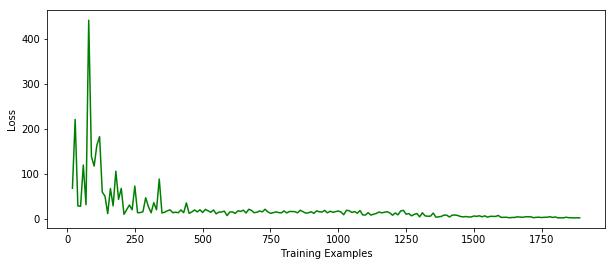

In [68]:
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
#ax1.plot(x, np.array(train_losses).ravel())
#ax1.plot(x, np.array(val_losses).ravel(),'r')
ax1.plot(x[2:], (np.array(((np.array(metrics["val_loss"])) ))[2:]).ravel(),'g')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

Training...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


Iterations : 10 Lambda : 0.00, Threshold : 0.90
Mean Validation loss : 2.04, precision : 0.62, recall : 0.67, F : 0.64
Sigma Validation loss : 0.38, precision : 0.03, recall : 0.08, F : 0.04
Training...
Iterations : 10 Lambda : 0.01, Threshold : 0.90
Mean Validation loss : 0.90, precision : 0.65, recall : 0.27, F : 0.38
Sigma Validation loss : 0.06, precision : 0.04, recall : 0.04, F : 0.03
Optimal value for lambda is 0.01


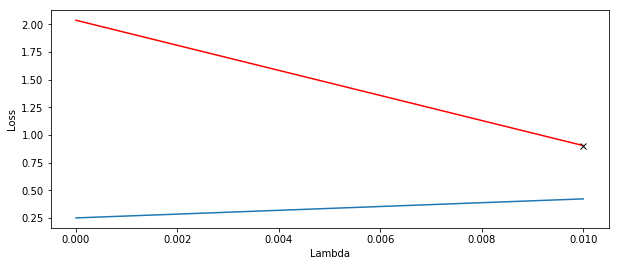

In [47]:
###
### LAMBDA OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

#lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]#, 0.3, 1.0, 3.0, 10.0]
#lams = np.arange(0.02,.04, .001)
lams = [0.0, 0.01]

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

for i in lams:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: i},
            {train_data_node: val_X, train_labels_node: val_y, lam: i},
             THRESHOLD,
              10
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
     

lam_opt = lams[np.argmin(metrics["val_loss"])]
print("Optimal value for lambda is %s" % lam_opt)
    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(lams, np.array(metrics["train_loss"]).ravel())
ax1.plot(lams, np.array(metrics["val_loss"]).ravel(),'r')
ax1.plot(lams[np.argmin(metrics["val_loss"])], metrics["val_loss"][np.argmin(metrics["val_loss"])], 'x', color='black')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Lambda")
plt.show()

In [ ]:
###
### THRESHOLD OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

mylam = 0.0
threshold = 0
thresholds = [.5, .8, .9, .99, .999]
lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 1.0]

for i in thresholds:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: mylam},
            {train_data_node: val_X, train_labels_node: val_y, lam: mylam},
             i
            ) 
    
print("Done")


In [35]:

predictions = miassembly.get_predictions_with_dataset_id(DATASET_ID1, "5404d26bccc568c4bddfc45f37d8fbfb", start="2016-07-06", end="2016-11-09")




In [7]:
ds,_ = mi.get_dataset_by_id(DATASET_ID1)

In [8]:
_, test_y = ppl.splitCol(ds["2016-07-06":"2016-11-09"], 9)

In [9]:
test_y.shape

(90, 1)

In [44]:
predictions.shape

(90, 1)

In [45]:
a = ppl.onehot(np.vstack(getPredictionSignals(predictions.values, 0)))
b = ppl.onehot(np.vstack(getPredictionSignals(test_y, 0)))
mlutils.evaluate(a, b, .0)

(0.5888889, 1.0, 0.7412587370614363)

In [46]:
mlutils.evaluate(ppl.onehot(predictions.values), ppl.onehot(test_y), .0)

(0.5888889, 1.0, 0.7412587370614363)

In [12]:
getPredictionSignals(ppl.onehot(predictions.values), 0)


NameError: name 'predictions' is not defined

In [13]:
getPredictionSignals(test_y,0)

array([ 1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.])

In [49]:
mlutils.getSignals(ppl.onehot(predictions.values), ppl.onehot(test_y), 0)

array([-1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,
        1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.])

In [3]:
def getPredictionSignals(predictions, threshold):
    signals = np.ones(len(predictions))
    a = np.argmax(ppl.onehot(predictions),axis=1)
    signals[(a==1)] = -1 # Set any DOWN signals to -1 (UP signals will pick up the default of 1)
    signals[(predictions < threshold).all(axis=1)] = 0
    return signals